<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/AFD_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install "torch==2.4.0" tensorboard pillow torchvision accelerate huggingface_hub
!pip -q install  --upgrade \
  "transformers==4.45.1" \
  "datasets==3.0.1" \
  "accelerate==0.34.2" \
  "evaluate==0.4.3" \
  "bitsandbytes==0.44.0" \
  "trl==0.11.1" \
  "peft==0.13.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.3/797.3 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.4/209.4 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 91.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.5.1+cu121 requires torch==2.5.1, but you have torch 2.4.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 115.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━

In [ ]:
system_message = """You are a Vision Language Model specialized in interpreting visual data from chart images.
Your task is to analyze the provided chart image and respond to queries with concise answers, usually a single word, number, or short phrase.
The charts include a variety of types (e.g., line charts, bar charts) and contain colors, labels, and text.
Focus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary."""

def format_data(sample):
    return [
        {
            "role": "system",
            "content": [
                {
                    "type": "text",
                    "text": system_message
                }
            ],
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": sample["image"],
                },
                {
                    "type": "text",
                    "text": sample['query'],
                }
            ],
        },
        {
            "role": "assistant",
            "content": [
                {
                    "type": "text",
                    "text": sample["label"][0]
                }
            ],
        },
    ]

from datasets import load_dataset

dataset_id = "HuggingFaceM4/ChartQA"
train_dataset, eval_dataset, test_dataset = load_dataset(dataset_id, split=['train[:10%]', 'val[:10%]', 'test[90%:]'])

train_dataset = [format_data(sample) for sample in train_dataset]
eval_dataset = [format_data(sample) for sample in eval_dataset]
test_dataset = [format_data(sample) for sample in test_dataset]

train_dataset[200], len(train_dataset), len(eval_dataset), len(test_dataset)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/852 [00:00<?, ?B/s]

(…)-00000-of-00003-49492f364babfa44.parquet:   0%|          | 0.00/219M [00:00<?, ?B/s]

(…)-00001-of-00003-7302bae5e425bbc7.parquet:   0%|          | 0.00/311M [00:00<?, ?B/s]

(…)-00002-of-00003-194c9400785577a2.parquet:   0%|          | 0.00/315M [00:00<?, ?B/s]

(…)-00000-of-00001-0f11003c77497969.parquet:   0%|          | 0.00/50.2M [00:00<?, ?B/s]

(…)-00000-of-00001-e2cd0b7a0f9eb20d.parquet:   0%|          | 0.00/68.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/28299 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/1920 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2500 [00:00<?, ? examples/s]

([{'role': 'system',
   'content': [{'type': 'text',
     'text': 'You are a Vision Language Model specialized in interpreting visual data from chart images.\nYour task is to analyze the provided chart image and respond to queries with concise answers, usually a single word, number, or short phrase.\nThe charts include a variety of types (e.g., line charts, bar charts) and contain colors, labels, and text.\nFocus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary.'}]},
  {'role': 'user',
   'content': [{'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=308x369>},
    {'type': 'text',
     'text': 'Is the rightmost value of light brown graph 58?'}]},
  {'role': 'assistant', 'content': [{'type': 'text', 'text': 'No'}]}],
 2830,
 192,
 250)

In [ ]:
import evaluate
import torch
from nltk.translate.meteor_score import meteor_score, single_meteor_score
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
import requests
from torch import nn
from transformers import MllamaForConditionalGeneration, AutoProcessor, MllamaConfig, AutoModelForCausalLM
from typing import List, Optional, Tuple, Union
from PIL import Image
import matplotlib.pyplot as plt
from transformers import BitsAndBytesConfig

def generate_text_from_sample(model, processor, sample, max_new_tokens=1024, device="cuda"):
    # Prepare the text input by applying the chat template
    text_input = processor.apply_chat_template(
        sample[1:2],  # Use the sample without the system message
        tokenize=False,
        add_generation_prompt=True
    )

    # Process the visual input from the sample
    # image_inputs, _ = process_vision_info(sample)
    image_inputs = sample[1]['content'][0]['image'].convert("RGB")
    # Prepare the inputs for the model
    model_inputs = processor(
        text=[text_input],
        images=image_inputs,
        return_tensors="pt",
    ).to(device)  # Move inputs to the specified device

    # Generate text with the model
    generated_ids = model.generate(**model_inputs, max_new_tokens=max_new_tokens, return_dict_in_generate=True,
                    output_scores=True,
                    output_hidden_states=True,
                    do_sample=True,
                    # stopping_criteria=stopping_criteria,
                    # pad_token_id=pad_token_id,
                                )

    # Trim the generated ids to remove the input ids
    trimmed_generated_ids = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(model_inputs.input_ids, generated_ids[0])
    ]

    # Decode the output text
    output_text = processor.batch_decode(
        trimmed_generated_ids,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False
    )

    return generated_ids, output_text[0]  # Return the first decoded output text

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    # low_cpu_mem_usage=True,
    # bnb_4bit_compute_dtype=torch.float16
)

model_id = "meta-llama/Llama-3.2-11B-Vision-Instruct"
processor = AutoProcessor.from_pretrained(model_id)
model = MllamaForConditionalGeneration.from_pretrained(
            model_id, torch_dtype=torch.bfloat16, device_map="auto", low_cpu_mem_usage=True,
            quantization_config=quantization_config,
        )

all_pred = []
all_ans = []
all_gens = []
i = 0

model.eval()
with torch.no_grad():
    for sample in test_dataset:
        generation, output = generate_text_from_sample(model, processor, sample)
        all_gens.append(generation)
        #calculate evaluation metrics
        ans = sample[2]['content'][0]['text']
        all_pred.append(output)
        all_ans.append(ans)

        i += 1
        if i>49:
            break

preprocessor_config.json:   0%|          | 0.00/437 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.8k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/5.07k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/5.09k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/89.4k [00:00<?, ?B/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.47G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.23 GiB. GPU 0 has a total capacity of 14.75 GiB of which 551.06 MiB is free. Process 2369 has 14.21 GiB memory in use. Of the allocated memory 11.95 GiB is allocated by PyTorch, and 2.14 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
len(all_gens), all_gens[0].keys(), all_gens[0]['scores'][0].shape, all_gens[0]['sequences'].shape

In [ ]:
import numpy as np

def transitional_score(scores, sequences):
    beam_indices = torch.arange(scores[0].shape[0]).view(-1, 1).to(sequences.device)
    beam_indices = beam_indices.expand(-1, len(scores))
    scores = torch.stack(scores).reshape(len(scores), -1).transpose(0, 1)
    scores = scores.reshape(-1, model.config.text_config.vocab_size, scores.shape[-1])
    scores = torch.nn.functional.log_softmax(scores, dim=1)
    scores = scores.reshape(-1, scores.shape[-1])

    beam_indices_mask = beam_indices < 0
    max_beam_length = (1 - beam_indices_mask.long()).sum(-1).max()

    cut_idx = sequences.shape[-1] - max_beam_length
    beam_sequence_indices = beam_indices * model.config.text_config.vocab_size

    indices = sequences[:, cut_idx:] + beam_sequence_indices
    transition_scores = scores.gather(0, indices)
    transition_scores[beam_indices_mask] = 0

    return transition_scores

def predictive_entropy(log_probs):
    """Compute MC estimate of entropy.

    `E[-log p(x)] ~= -1/N sum_i log p(x_i)`, i.e. the average token likelihood.
    """
    # print("log_probs", log_probs)
    entropy = -np.sum(log_probs) / len(log_probs)

    return entropy

#get all transitional score and calculate entropy
all_entropy = []
for i in range(len(all_gens)):
    score = all_gens[i]['scores']
    sequences = all_gens[i]['sequences']
    transition_scores = transitional_score(score, sequences)
    # print("transition_scores", transition_scores)

    log_likelihoods = [score.item() for score in transition_scores[0]]
    log_liks_agg = [np.mean(log_lik) for log_lik in log_likelihoods]
    naive_entropy_temp = predictive_entropy(log_liks_agg)

    all_entropy.append(naive_entropy_temp)

In [ ]:
#use RougeL as the proxy for accuracy
rouge = evaluate.load("rouge")

all_rouge = []
all_acc = []
for i in range(len(all_pred)):
    rouge_result = rouge.compute(predictions= [all_pred[i]], references=[all_ans[i]])
    if rouge_result['rougeL']>0.15:
        acc = 1
    else:
        acc = 0
    all_acc.append(acc)
    all_rouge.append(rouge_result)

overall_acc = sum(all_acc)/len(all_acc)
print('overall_acc:', overall_acc)


entropy_ = torch.tensor(all_entropy)
entropy_sort = torch.sort(entropy_)
print('entropy_sort:', entropy_sort)

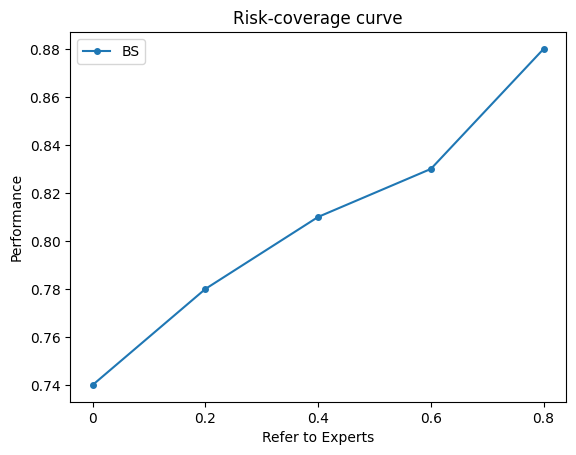

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

refer = np.array(['0' , 0.2 , 0.4 ,  0.6 ,  0.8  ])
proposed = np.array([0.74, 0.78, 0.81, 0.83, 0.88])


all = np.array([proposed])

ax = plt.gca()
lineObjects = ax.plot(refer, all.transpose(),marker='o',markersize=4)
legends = ['BS']
ax.legend(lineObjects, legends)
ax.set_ylabel('Performance')
ax.set_xlabel("Refer to Experts")
ax.set_title('Risk-coverage curve');
plt.savefig("Risk_coverage_curve.pdf", bbox_inches='tight', dpi=1500)